
# Exhaustive EDA — Task 1 (Brent Prices + Events)

This notebook covers the **full** Task 1 scope:
- Robust data loading & validation (supports dates like `20-May-87`)
- Price & log-return visuals
- Rolling stats, distribution, outliers
- Stationarity diagnostics (ADF), ACF/PACF
- STL decomposition, resampling (weekly/monthly)
- **Event overlay** and **event-window** analysis
- Exports: figures to `../reports/figures/` and CSV summaries


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from pathlib import Path
from typing import Optional, List, Tuple

# Display
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["figure.dpi"] = 110

# Base paths, mirroring user's snippet but adding robust fallbacks
DATA_DIR = Path("../data")
# User's FIG_DIR had a typo path; we'll support it and also create ../reports/figures
FIG_DIRS = [Path("../data/reports/figures"), Path("../reports/figures")]
for p in FIG_DIRS:
    p.mkdir(parents=True, exist_ok=True)

# Primary file targets (as the user wrote)
PRICES_CSV = DATA_DIR / "BrentOilPrices.csv"
EVENTS_CSV = DATA_DIR / "events_compiled.csv"

# Fallbacks if those are missing
FALLBACK_PRICE_PATHS = [
    PRICES_CSV,
    DATA_DIR / "brent_prices.csv",
    Path("/mnt/data/BrentOilPrices.csv"),
    Path("/mnt/data/brent_prices.csv"),
]
FALLBACK_EVENT_PATHS = [
    EVENTS_CSV,
    DATA_DIR / "events.csv",
    Path("/mnt/data/events_compiled.csv"),
]

def resolve_first_existing(paths: List[Path]) -> Optional[Path]:
    for p in paths:
        if p.exists():
            return p
    return None

PRICE_PATH = resolve_first_existing(FALLBACK_PRICE_PATHS)
EVENT_PATH = resolve_first_existing(FALLBACK_EVENT_PATHS)

print("Resolved PRICE_PATH:", PRICE_PATH)
print("Resolved EVENT_PATH:", EVENT_PATH)
assert PRICE_PATH is not None, "No price file found. Place BrentOilPrices.csv in ../data or /mnt/data."
assert EVENT_PATH is not None, "No events file found. Place events_compiled.csv in ../data or /mnt/data."


Resolved PRICE_PATH: ../data/BrentOilPrices.csv
Resolved EVENT_PATH: ../data/events_compiled.csv


In [2]:

from datetime import datetime, timedelta

def load_prices(path: Path) -> pd.DataFrame:
    """Robust loader for Brent prices supporting '20-May-87' and general formats."""
    df = pd.read_csv(path)
    # Identify likely date/price columns
    date_col = "Date" if "Date" in df.columns else df.columns[0]
    price_col = "Price" if "Price" in df.columns else df.columns[1]

    # Try strict format first (20-May-87 -> %d-%b-%y), then fallback parses
    for fmt in ["%d-%b-%y", "%Y-%m-%d", None]:
        try:
            if fmt:
                dt = pd.to_datetime(df[date_col], format=fmt, errors="coerce")
            else:
                dt = pd.to_datetime(df[date_col], dayfirst=True, errors="coerce")
            if dt.notna().mean() > 0.95:  # good parse
                df[date_col] = dt
                break
        except Exception:
            continue

    # Coerce price to numeric
    df[price_col] = pd.to_numeric(df[price_col], errors="coerce")
    # Clean and index
    df = df.dropna(subset=[date_col]).sort_values(date_col)
    df = df.drop_duplicates(subset=[date_col])
    df = df.set_index(date_col)
    df = df.rename(columns={price_col: "Price"})
    return df[["Price"]]

def basic_quality_report(df: pd.DataFrame) -> dict:
    return {
        "start_date": str(df.index.min().date()) if len(df) else None,
        "end_date": str(df.index.max().date()) if len(df) else None,
        "row_count": int(len(df)),
        "duplicate_dates": int(df.index.duplicated().sum()),
        "missing_price": int(df["Price"].isna().sum()),
        "min_price": float(df["Price"].min()) if len(df) else None,
        "max_price": float(df["Price"].max()) if len(df) else None,
    }

def compute_log_returns(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["log_ret"] = np.log(out["Price"] / out["Price"].shift(1))
    return out

def zscore(series: pd.Series) -> pd.Series:
    return (series - series.mean()) / series.std(ddof=0)

def savefig_all(fig_name: str):
    for d in FIG_DIRS:
        try:
            plt.gcf().savefig(d / fig_name, bbox_inches="tight")
        except Exception:
            pass


## 1) Load & Validate Data

In [3]:

df = load_prices(PRICE_PATH)
# Forward-fill small gaps (document this choice)
df["Price"] = df["Price"].ffill()

report = basic_quality_report(df)
print("Quality Report:", report)

display(df.head())
display(df.tail())
display(df.describe(include="all"))
print("Missing per column:\n", df.isna().sum())


Quality Report: {'start_date': '1987-05-20', 'end_date': '2022-11-14', 'row_count': 9011, 'duplicate_dates': 0, 'missing_price': 0, 'min_price': 9.1, 'max_price': 143.95}


/var/folders/rs/66tw0l1j76s5bb6g3gcl7lm00000gn/T/ipykernel_57245/1210037259.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt = pd.to_datetime(df[date_col], dayfirst=True, errors="coerce")


,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


,Price
Date,
2022-11-08,96.85
2022-11-09,93.05
2022-11-10,94.25
2022-11-11,96.37
2022-11-14,93.59


,Price
count,9011.000000
mean,48.420782
std,32.860110
min,9.100000
25%,19.050000
50%,38.570000
75%,70.090000
max,143.950000


Missing per column:
 Price    0
dtype: int64


## 2) Core Visuals: Price & Log-Returns

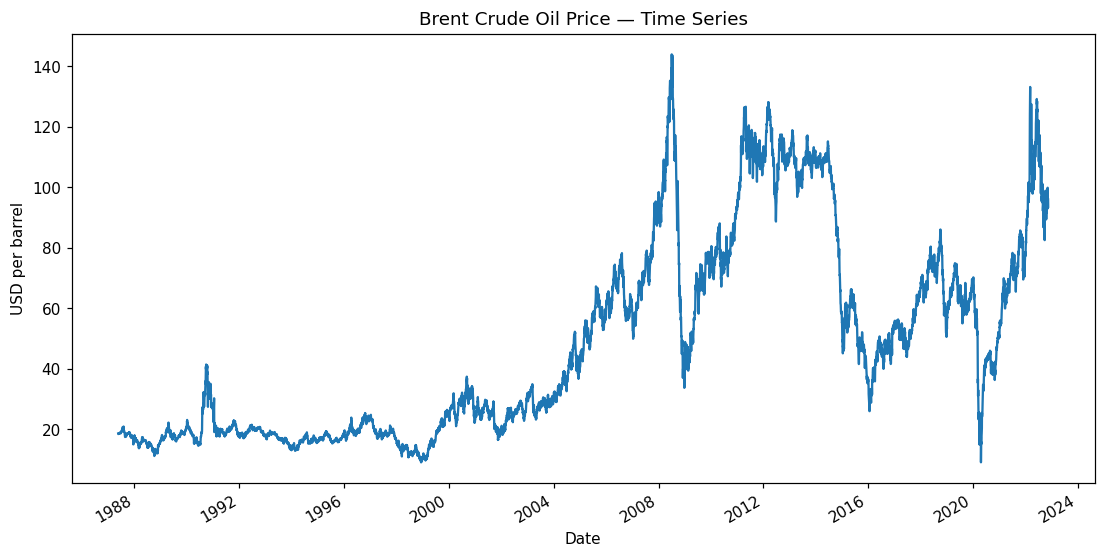

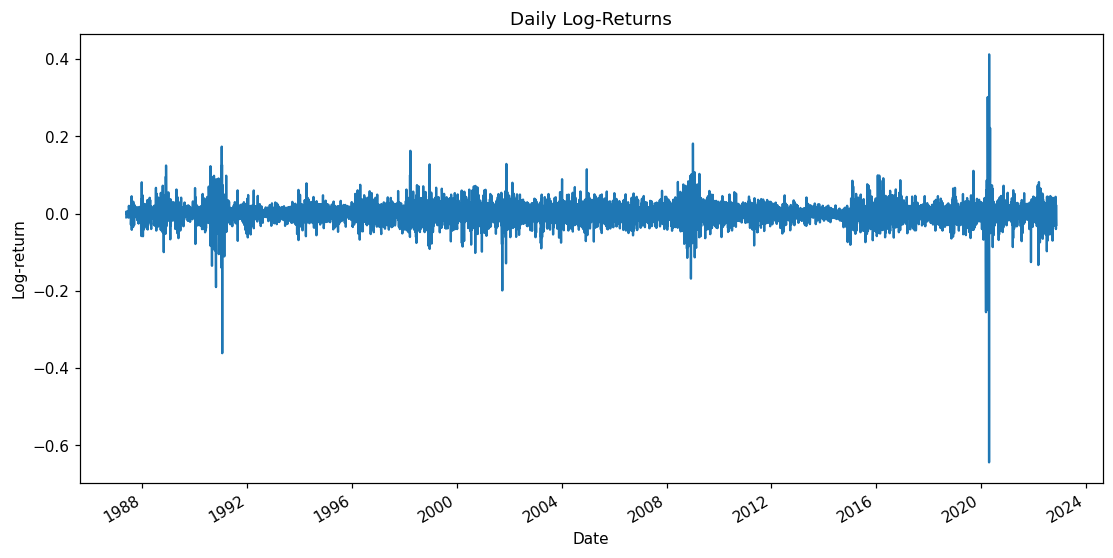

In [4]:

# Price series
ax = df["Price"].plot(title="Brent Crude Oil Price — Time Series")
ax.set_xlabel("Date"); ax.set_ylabel("USD per barrel")
savefig_all("price_series.png")
plt.show()

# Log-returns
df = compute_log_returns(df)
ax = df["log_ret"].dropna().plot(title="Daily Log-Returns")
ax.set_xlabel("Date"); ax.set_ylabel("Log-return")
savefig_all("log_returns.png")
plt.show()


## 3) Rolling Statistics & Volatility

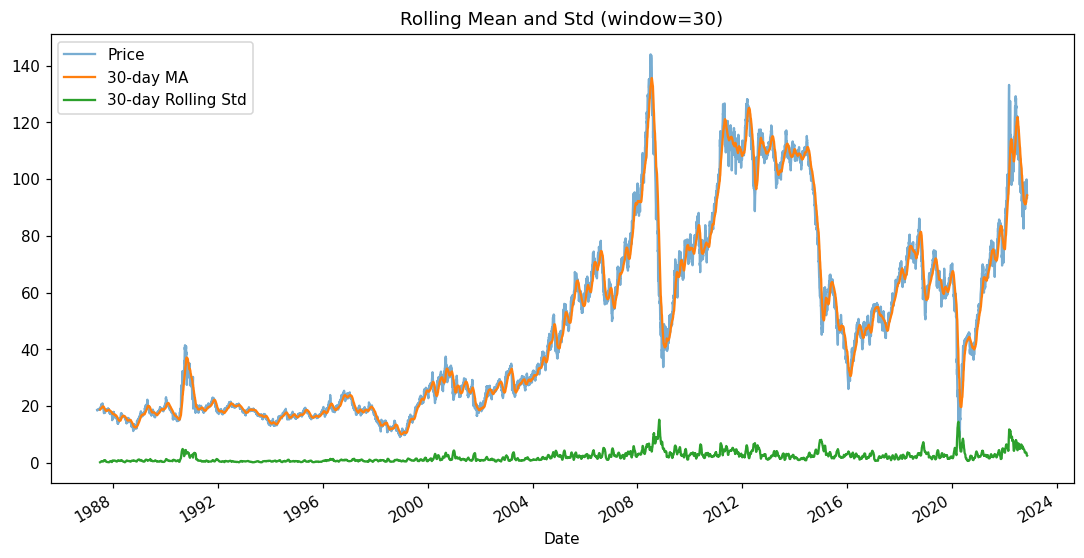

In [5]:

roll = 30
ax = df["Price"].plot(alpha=0.6, label="Price")
df["Price"].rolling(roll).mean().plot(ax=ax, label=f"{roll}-day MA")
df["Price"].rolling(roll).std().plot(ax=ax, label=f"{roll}-day Rolling Std")
ax.set_title(f"Rolling Mean and Std (window={roll})"); ax.legend()
savefig_all("rolling_stats.png")
plt.show()


## 4) Distribution, Outliers, and Top Moves

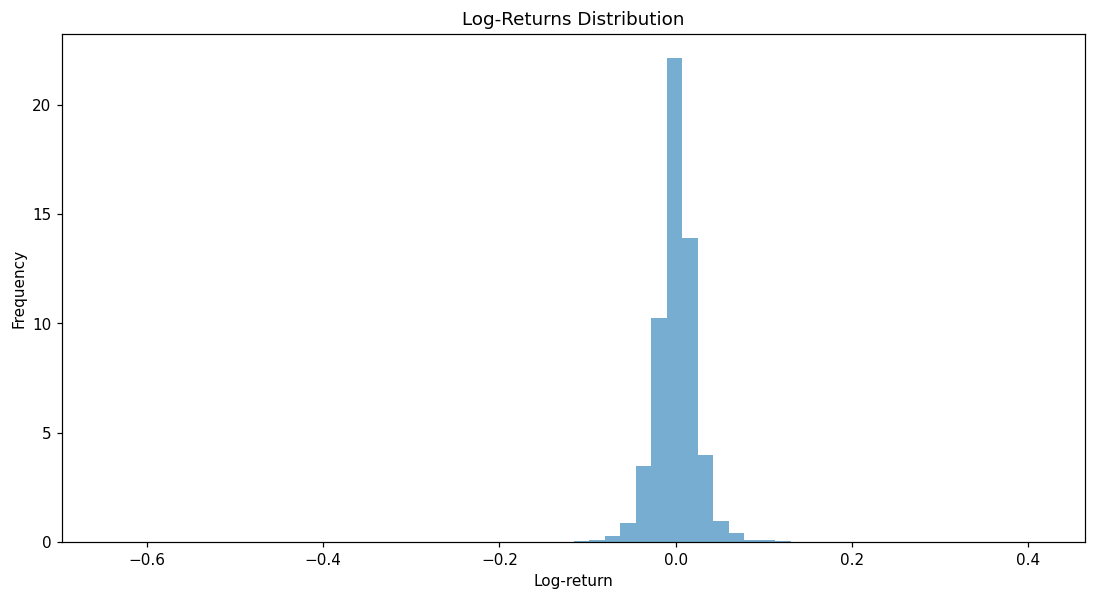

Outlier days (|z|>3): 100


,log_ret
Date,
2020-04-22,0.412023
2020-04-02,0.301613
2020-05-05,0.221574
2020-04-03,0.184049
2009-01-02,0.181297
1991-01-10,0.173333
1998-03-23,0.162559
2020-04-29,0.135293
2020-04-08,0.132060


,log_ret
Date,
2020-04-21,-0.643699
1991-01-17,-0.361214
2020-03-09,-0.255175
2020-04-01,-0.248341
2020-04-09,-0.220471
2001-09-24,-0.198906
1990-10-22,-0.190184
2008-12-05,-0.168320
2020-03-16,-0.162875


In [6]:

# Histogram
ax = df["log_ret"].dropna().plot(kind="hist", bins=60, density=True, alpha=0.6, title="Log-Returns Distribution")
ax.set_xlabel("Log-return")
savefig_all("log_returns_hist.png")
plt.show()

# Z-score outliers on returns
z = zscore(df["log_ret"].dropna())
df.loc[z.index, "ret_z"] = z
df["outlier_flag"] = (df["ret_z"].abs() > 3).astype(int)
print("Outlier days (|z|>3):", int(df["outlier_flag"].sum()))

# Top/bottom 10 daily moves
top_moves = df["log_ret"].dropna().sort_values(ascending=False).head(10).to_frame("log_ret")
bottom_moves = df["log_ret"].dropna().sort_values(ascending=True).head(10).to_frame("log_ret")
top_moves.to_csv("../reports/figures/top10_moves.csv")
bottom_moves.to_csv("../reports/figures/bottom10_moves.csv")
display(top_moves)
display(bottom_moves)


## 5) Stationarity (ADF), ACF & PACF

{'adf_stat': np.float64(-16.42711349448584), 'p_value': np.float64(2.4985801611432103e-29), 'n_obs': 8981, 'crit': {'1%': np.float64(-3.4310783342658615), '5%': np.float64(-2.861861876398633), '10%': np.float64(-2.566941329781918)}}


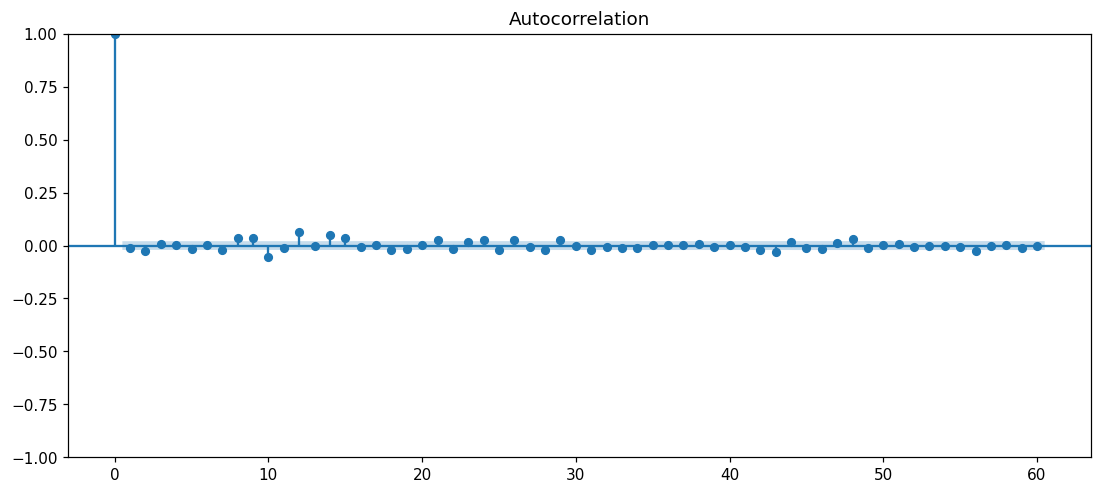

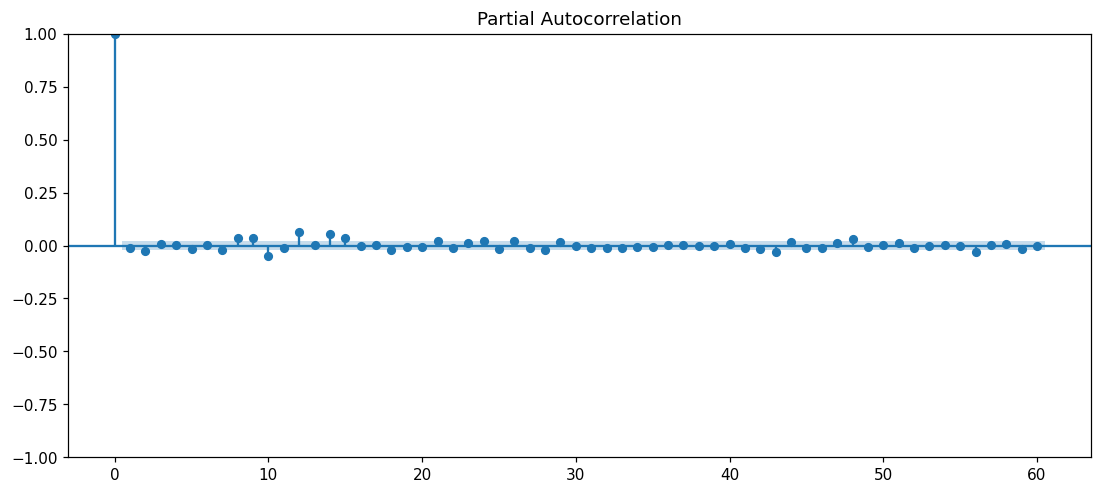

In [7]:

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

series = df["log_ret"].dropna()
adf = adfuller(series, autolag="AIC")
print({"adf_stat": adf[0], "p_value": adf[1], "n_obs": adf[3], "crit": adf[4]})

fig1 = plot_acf(series, lags=60)
fig1.set_size_inches(12,5)
savefig_all("acf_log_returns.png")
plt.show()

fig2 = plot_pacf(series, lags=60, method="ywm")
fig2.set_size_inches(12,5)
savefig_all("pacf_log_returns.png")
plt.show()


## 6) Seasonality & Trend (STL Decomposition)

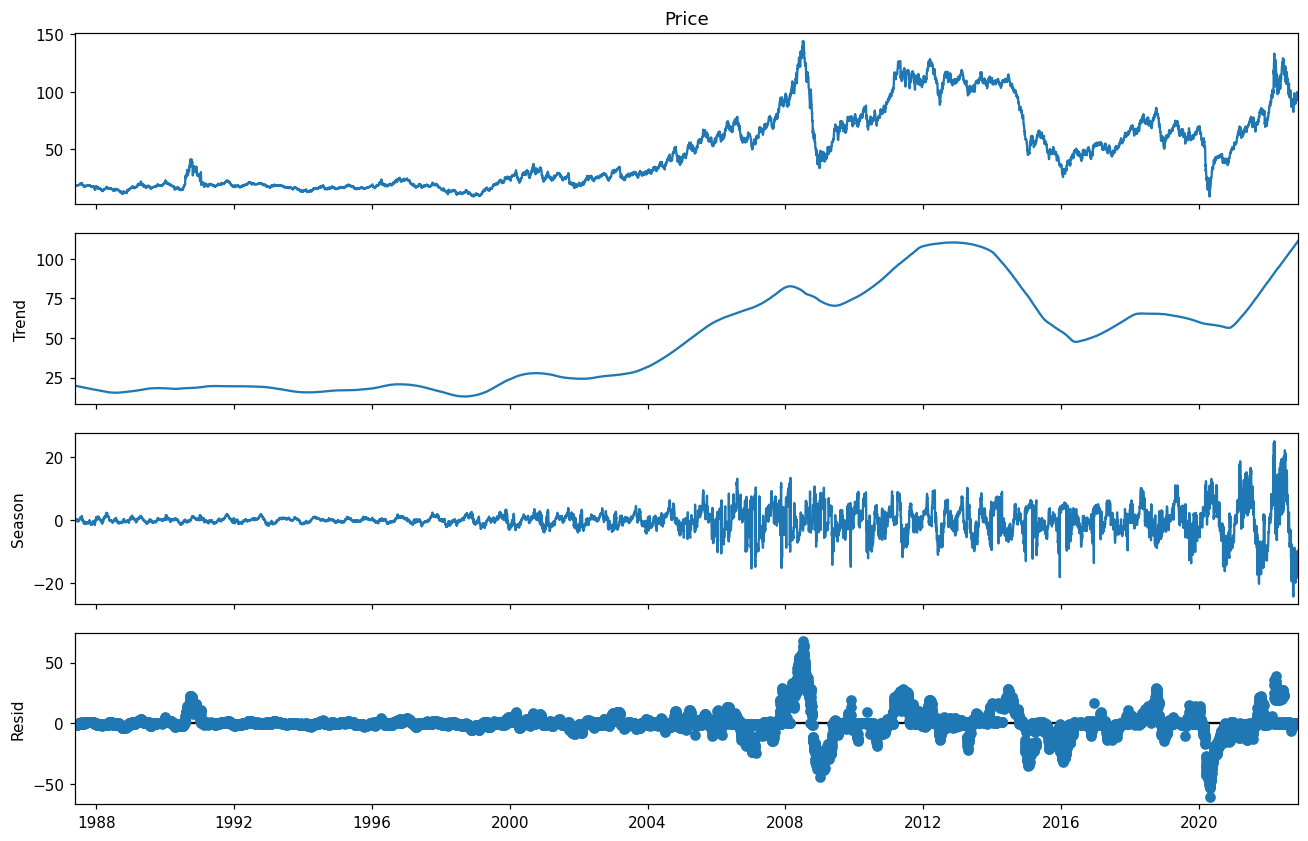

In [8]:

from statsmodels.tsa.seasonal import STL

try:
    stl = STL(df["Price"].dropna(), period=252, robust=True).fit()
    fig = stl.plot()
    fig.set_size_inches(12,8)
    for d in FIG_DIRS:
        fig.savefig(d / "stl_decomposition.png", bbox_inches="tight")
    plt.show()
except Exception as e:
    warnings.warn(f"STL decomposition skipped: {e}")


## 7) Resampling Views (Weekly, Monthly)

/var/folders/rs/66tw0l1j76s5bb6g3gcl7lm00000gn/T/ipykernel_57245/3578834613.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df["Price"].resample("M").last()


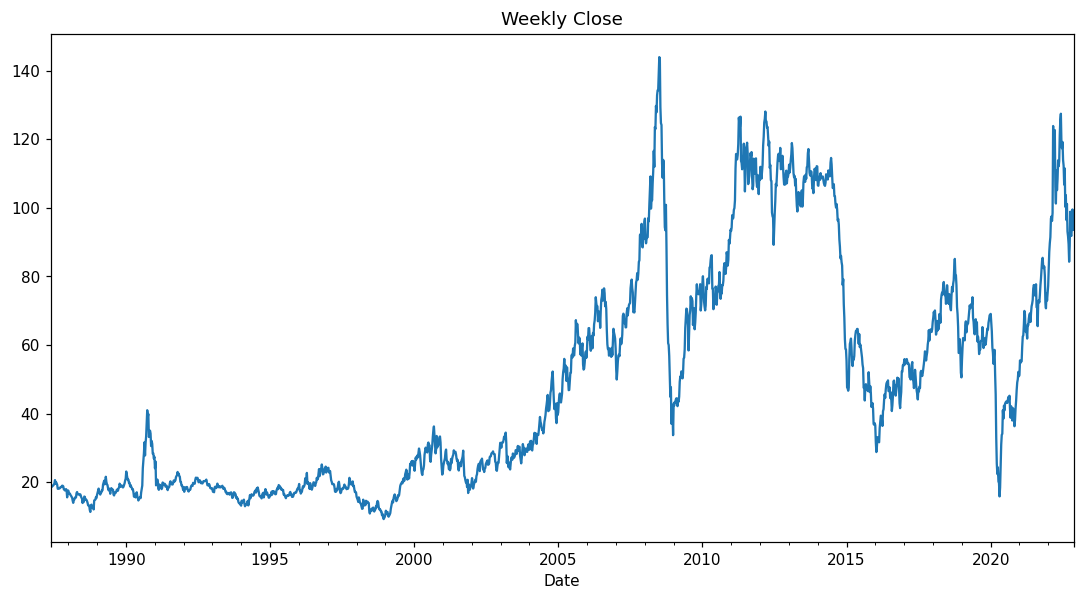

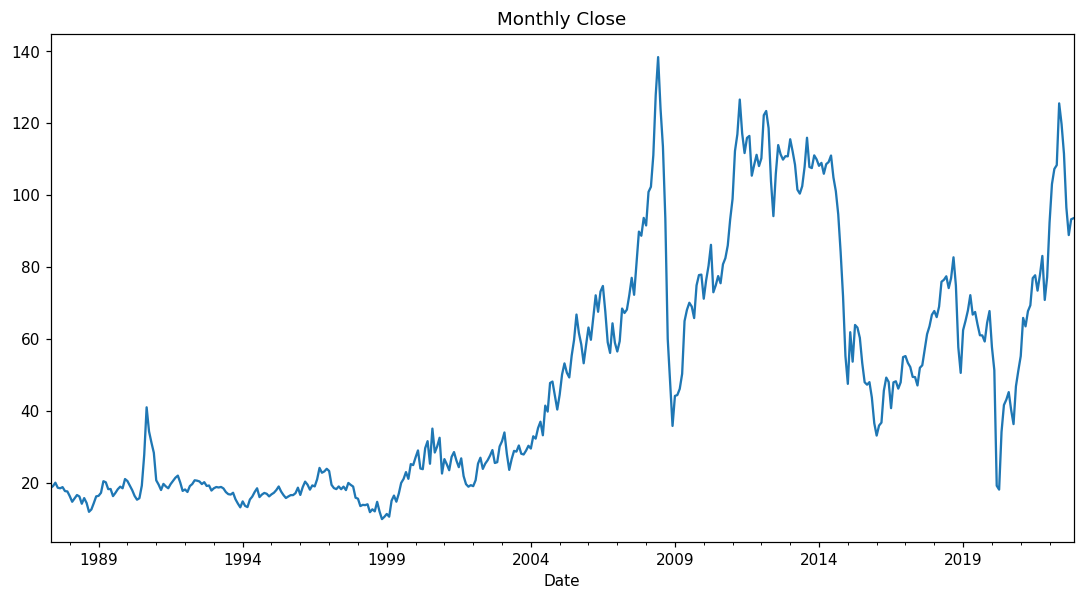

In [9]:

weekly = df["Price"].resample("W").last()
monthly = df["Price"].resample("M").last()

ax = weekly.plot(title="Weekly Close")
savefig_all("weekly_prices.png")
plt.show()

ax = monthly.plot(title="Monthly Close")
savefig_all("monthly_prices.png")
plt.show()


## 8) Load Events & Overlay

,event,start_date,type,region,source_url,notes
0,Iraq invades Kuwait (Gulf War begins),1990-08-02,geopolitical,Middle East,https://www.britannica.com/event/Persian-Gulf-War,Iraq's invasion of Kuwait triggers internation...
1,Operation Desert Storm air campaign begins,1991-01-17,geopolitical,Middle East,https://www.britannica.com/event/Persian-Gulf-War,Coalition air strikes to expel Iraqi forces fr...
2,Asian Financial Crisis begins (Thai baht deval...,1997-07-02,economic,Asia,https://www.federalreservehistory.org/essays/a...,Regional demand shock; contagion across East A...
3,Russian financial crisis and default,1998-08-17,economic,Russia,https://www.bis.org/cgfs/Gonzalez-Hermosillo-e...,Devaluation and default; global risk-off episode.
4,September 11 attacks (9/11),2001-09-11,geopolitical,United States,https://www.britannica.com/event/September-11-...,Terror attacks; global demand shock/flight to ...
5,U.S.-led invasion of Iraq,2003-03-20,geopolitical,Middle East,https://www.britannica.com/event/Iraq-War,Major supply risk in a key producer.
6,Hurricane Katrina landfall; Gulf energy disrup...,2005-08-29,weather/infrastructure,U.S. Gulf of Mexico,https://www.everycrsreport.com/reports/RL33124...,Large shut-ins of GOM production and refining.
7,BP Prudhoe Bay partial shutdown (pipeline corr...,2006-08-06,infrastructure,U.S. Alaska,https://www.everycrsreport.com/reports/RL33629...,Partial field shutdown due to severe corrosion.
8,Libyan Civil War unrest and supply disruption,2011-02-15,geopolitical,North Africa,https://www.britannica.com/event/Libya-Revolt-...,Output collapse; EIA estimated 60–90% drop in ...
9,OPEC opts not to cut production,2014-11-27,OPEC policy,Vienna,https://www.reuters.com/article/business/saudi...,Decision accelerates 2014–2016 oil price slump.


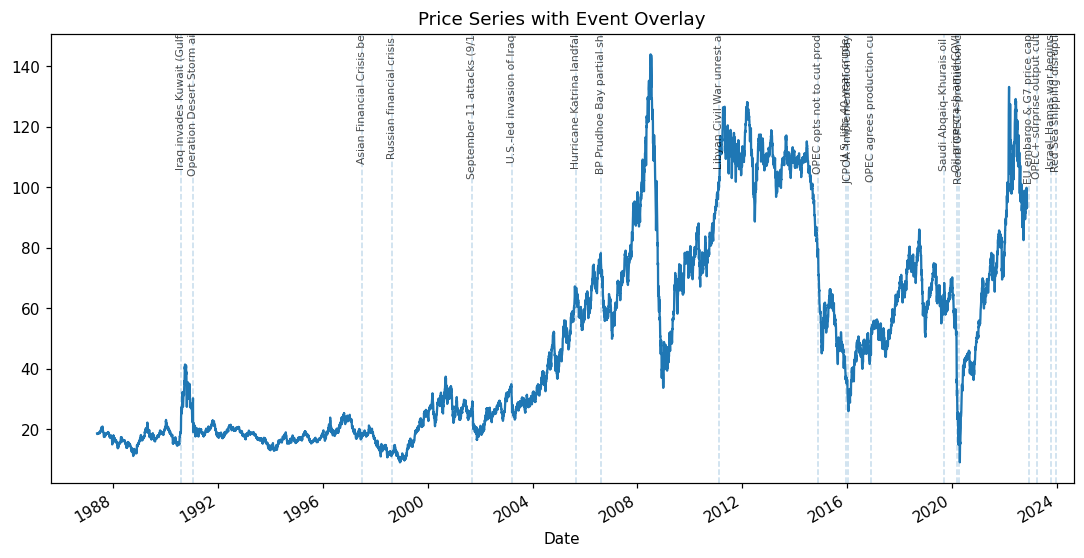

In [10]:

events = pd.read_csv(EVENT_PATH)
# Flexible parse for start_date
if "start_date" in events.columns:
    events["start_date"] = pd.to_datetime(events["start_date"], errors="coerce")
else:
    # fallback: first column as date if unnamed
    date_col = events.columns[1]
    events[date_col] = pd.to_datetime(events[date_col], errors="coerce")
    events = events.rename(columns={date_col: "start_date"})
events = events.dropna(subset=["start_date"]).sort_values("start_date")

label_col = "event" if "event" in events.columns else events.columns[0]
display(events.head(10))

ax = df["Price"].plot(title="Price Series with Event Overlay")
for _, row in events.iterrows():
    ax.axvline(row["start_date"], alpha=0.25, linestyle="--", linewidth=1)
    ax.text(row["start_date"], ax.get_ylim()[1], str(row[label_col])[:25],
            rotation=90, va="top", ha="center", fontsize=7, alpha=0.7)
savefig_all("price_with_events.png")
plt.show()


## 9) Event-Window Analysis (±30 days)

In [11]:

window_days = 30
df["in_event_window"] = 0

for _, row in events.iterrows():
    start = row["start_date"] - pd.Timedelta(days=window_days)
    end = row["start_date"] + pd.Timedelta(days=window_days)
    mask = (df.index >= start) & (df.index <= end)
    df.loc[mask, "in_event_window"] = 1

summary = {
    "mean_ret_in_window": float(df.loc[df["in_event_window"] == 1, "log_ret"].mean()),
    "mean_ret_outside": float(df.loc[df["in_event_window"] == 0, "log_ret"].mean()),
    "vol_in_window": float(df.loc[df["in_event_window"] == 1, "log_ret"].std()),
    "vol_outside": float(df.loc[df["in_event_window"] == 0, "log_ret"].std()),
    "days_in_window": int((df["in_event_window"]==1).sum()),
    "total_days": int(df["log_ret"].dropna().shape[0]),
}
print(summary)

# Save augmented series for later modeling
out_df = df[["Price", "log_ret", "ret_z", "outlier_flag", "in_event_window"]]
out_df.to_csv("../reports/figures/series_with_flags.csv")
display(out_df.head())


{'mean_ret_in_window': -0.0021621743919631262, 'mean_ret_outside': 0.0003596835431406917, 'vol_in_window': 0.053816757115588164, 'vol_outside': 0.021879403437332426, 'days_in_window': 645, 'total_days': 9010}


,Price,log_ret,ret_z,outlier_flag,in_event_window
Date,,,,,
1987-05-20,18.63,NaN,NaN,0,0
1987-05-21,18.45,-0.009709,-0.387296,0,0
1987-05-22,18.55,0.005405,0.204705,0,0
1987-05-25,18.60,0.002692,0.098416,0,0
1987-05-26,18.63,0.001612,0.056107,0,0



## 10) Data Dictionary (Outputs)
- `Price`: USD per barrel (forward-filled for gaps)
- `log_ret`: log return, `log(Price_t / Price_{t-1})`
- `ret_z`: z-score of `log_ret` over the full sample
- `outlier_flag`: 1 if `|z|>3`, else 0
- `in_event_window`: 1 if within ±30 days of any event start, else 0

## Notes / Assumptions
- Date parsing supports `20-May-87` and ISO formats. If your file differs, adjust loader.
- Forward-fill was applied to small gaps; document rationale in your report.
- Events are approximations; you may refine dates and add sources.
